In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from utils import load_data, load_json, retrieve_docs, precision_recall
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def cos_distance(P_k, g_j, q):
    q_k = P_k.T @ q
    return q_k.T @ g_j / (np.linalg.norm(q_k) * np.linalg.norm(g_j))

def vector_space_cos(a_j, q):
    return q.T @ a_j / (np.linalg.norm(q) * np.linalg.norm(a_j))

def cos_distance_NMF(Q, R, h_j, q):
    q_hat = np.linalg.solve(R, Q.T @ q)
    return q_hat.T @ h_j / (np.linalg.norm(q_hat) * np.linalg.norm(h_j))

In [3]:
def approximate_matrix(A, k):
    U, S, V = np.linalg.svd(A, full_matrices=False)
    H_k =  np.diag(S[:k]) @ V[:k, :]   
    U_k = U[:, :k]
    return U_k, H_k

def approximate_matrix_NMF(A, k):
    model = NMF(n_components=k, init='random', random_state=0, max_iter=100)
    W = model.fit_transform(A)
    H = model.components_
    return W, H

In [4]:
data_path = r"../data/text-mining-medline_stemmed.mat"
data = load_data(data_path)
# term document matrix
A = data["A"].A
q = data["q"].A
normalized_A  = A.copy()
normalized_A = normalize(normalized_A, axis=0, norm="l2")
print(np.linalg.norm(normalized_A[:, 2]))

0.9999999999999999


In [6]:
#Clustering method
kmeans = KMeans(n_clusters=50, random_state=0, n_init="auto").fit(normalized_A.T)
labels = kmeans.labels_
C_k = kmeans.cluster_centers_
C_k = C_k.T
# with open("centroids.txt", "w") as file:
#     for label in labels:
#         file.write(str(label) + "\n")

In [7]:
P_k, R = np.linalg.qr(C_k)
G_k = P_k.T @ normalized_A

m_q, n_q = q.shape
m_g, n_g = G_k.shape
clustering_distance_matrix = np.zeros((n_q, n_g))
vector_space_distance_matrix = np.zeros((n_q, n_g))
for i in range(n_q):
    for j in range(n_g):
        cos_dist = cos_distance(P_k, G_k[:, j], q[:, i])
        vector_space_distance = vector_space_cos(normalized_A[:,j], q[:, i])
        clustering_distance_matrix[i][j] = cos_dist
        vector_space_distance_matrix[i][j] = vector_space_distance

In [8]:
#LSI Method
U_k, H_k = approximate_matrix(A, 100)
m_q, n_q = q.shape
m_h, n_h = H_k.shape
LSI_distance_matrix = np.zeros((n_q, n_h))
for i in range(n_q):
    for j in range(n_h):
        cos_dist = cos_distance(U_k, H_k[:, j], q[:, i])
        LSI_distance_matrix[i][j] = cos_dist

In [9]:
#NMF method
W, H = approximate_matrix_NMF(A, 50)
Q, R = np.linalg.qr(W)
m_q, n_q = q.shape
m_h, n_h = H.shape
NMF_distance_matrix = np.zeros((n_q, n_h))
for i in range(n_q):
    for j in range(n_h):
        cos_dist = cos_distance_NMF(Q, R, H[:, j], q[:, i])
        NMF_distance_matrix[i][j] = cos_dist


C:\Users\akram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [12]:
json_dict = load_json(r"../data\med\MED.json")

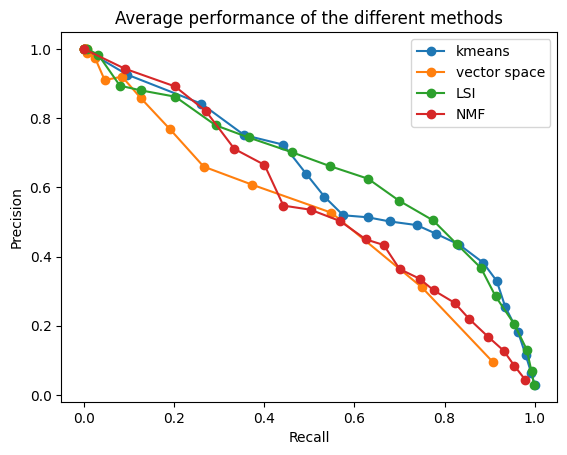

In [13]:
def calculate_metrics(distance_matrix, tolerance):
    precision_values = []
    recall_values = []
    
    for i, q_distances in enumerate(distance_matrix):
        retrieved_docs = retrieve_docs(q_distances, tolerance)
        precision, recall = precision_recall(json_dict, str(i + 1), retrieved_docs)
        precision_values.append(precision)
        recall_values.append(recall)

    avg_precision = sum(precision_values) / len(distance_matrix)
    avg_recall = sum(recall_values) / len(distance_matrix)

    return avg_precision, avg_recall

tol = np.linspace(0.0, 1.0, 20)

LSI_precision, LSI_recall = zip(*[calculate_metrics(LSI_distance_matrix, t) for t in tol])
NMF_precision, NMF_recall = zip(*[calculate_metrics(NMF_distance_matrix, t) for t in tol])
kmeans_precision, kmeans_recall = zip(*[calculate_metrics(clustering_distance_matrix, t) for t in tol])
vs_precision, vs_recall = zip(*[calculate_metrics(vector_space_distance_matrix, t) for t in tol])

plt.plot(kmeans_recall, kmeans_precision, 'o-', label="kmeans")
plt.plot(vs_recall, vs_precision, 'o-', label="vector space")
plt.plot(LSI_recall, LSI_precision, 'o-', label="LSI")
plt.plot(NMF_recall, NMF_precision, 'o-', label="NMF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average performance of the different methods")
plt.legend()
plt.show()